In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

In [2]:
# Define the base LeNet-5 architecture
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 16*4*4)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Architecture 2: LeNet-5 with one convolutional layer removed
class LeNet5_OneConv(nn.Module):
    def __init__(self):
        super(LeNet5_OneConv, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.fc1 = nn.Linear(6*12*12, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 6*12*12)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# # Architecture 3: LeNet-5 with an additional convolutional layer
class LeNet5_ExtraConv(nn.Module):
    def __init__(self):
        super(LeNet5_ExtraConv, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3)
        
        # Update the input size for the first fully connected layer
        self.fc1 = nn.Linear(32*3*3, 120)  # Adjust size based on the output of conv3
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv3(x))
        x = torch.max_pool2d(x, 2)
        
        # Ensure the output is flattened correctly for the linear layers
        x = x.view(-1, 32*3*3)  # Adjust this size based on the output of the conv layers
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Data preparation
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Function to train the model and compute accuracy
def train_model(model, num_epochs=10):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    train_loss_list = []
    test_loss_list = []
    train_accuracy_list = []
    test_accuracy_list = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0
        
        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Track training loss
            train_loss += loss.item()
            
            # Calculate the number of correct predictions for accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        # Calculate average training loss and accuracy
        train_loss_list.append(train_loss / len(train_loader))
        train_accuracy_list.append(100 * correct_train / total_train)
        
        # Testing the model after each epoch
        model.eval()
        test_loss = 0
        correct_test = 0
        total_test = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                # Track test loss
                test_loss += loss.item()
                
                # Calculate accuracy during testing
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
        
        # Calculate average test loss and accuracy
        test_loss_list.append(test_loss / len(test_loader))
        test_accuracy_list.append(100 * correct_test / total_test)
        
        # Print epoch results (optional)
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss_list[-1]:.4f}, '
              f'Train Accuracy: {train_accuracy_list[-1]:.2f}%, '
              f'Test Loss: {test_loss_list[-1]:.4f}, '
              f'Test Accuracy: {test_accuracy_list[-1]:.2f}%')
    
    return train_loss_list, test_loss_list, train_accuracy_list, test_accuracy_list


# Setting device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Train the three models
lenet5_model = LeNet5()
lenet5_oneconv_model = LeNet5_OneConv()
# lenet5_extraconv_model = LeNet5_ExtraConv()

# Now, let's train all the models and store the training and test loss for comparison
# Entrenamiento de los modelos con cálculo de precisión
train_loss_base, test_loss_base, train_acc_base, test_acc_base = train_model(lenet5_model)
train_loss_oneconv, test_loss_oneconv, train_acc_oneconv, test_acc_oneconv = train_model(lenet5_oneconv_model)
# train_loss_extraconv, test_loss_extraconv, train_acc_extraconv, test_acc_extraconv = train_model(lenet5_extraconv_model)

# Las listas 'train_acc_base', 'test_acc_base', etc. ahora contienen las precisiones de entrenamiento y prueba por cada epoch.


Epoch [1/10], Train Loss: 0.2552, Train Accuracy: 92.25%, Test Loss: 0.0689, Test Accuracy: 97.88%
Epoch [2/10], Train Loss: 0.0693, Train Accuracy: 97.94%, Test Loss: 0.0470, Test Accuracy: 98.61%
Epoch [3/10], Train Loss: 0.0494, Train Accuracy: 98.50%, Test Loss: 0.0479, Test Accuracy: 98.49%
Epoch [4/10], Train Loss: 0.0392, Train Accuracy: 98.73%, Test Loss: 0.0379, Test Accuracy: 98.78%
Epoch [5/10], Train Loss: 0.0317, Train Accuracy: 98.97%, Test Loss: 0.0379, Test Accuracy: 98.84%
Epoch [6/10], Train Loss: 0.0279, Train Accuracy: 99.08%, Test Loss: 0.0385, Test Accuracy: 98.73%
Epoch [7/10], Train Loss: 0.0239, Train Accuracy: 99.20%, Test Loss: 0.0418, Test Accuracy: 98.72%
Epoch [8/10], Train Loss: 0.0214, Train Accuracy: 99.28%, Test Loss: 0.0368, Test Accuracy: 98.94%
Epoch [9/10], Train Loss: 0.0184, Train Accuracy: 99.43%, Test Loss: 0.0365, Test Accuracy: 98.95%
Epoch [10/10], Train Loss: 0.0154, Train Accuracy: 99.48%, Test Loss: 0.0552, Test Accuracy: 98.59%
Epoch [1/

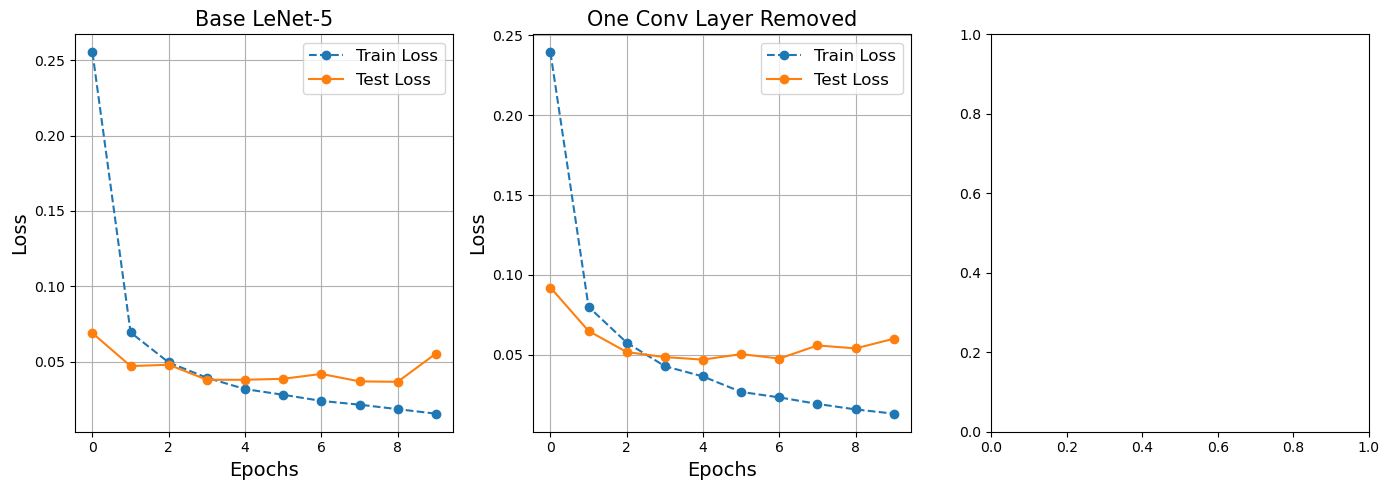

In [3]:
import matplotlib.pyplot as plt


# Ajusta el tamaño de la figura con figsize=(ancho, altura)
fig, axs = plt.subplots(1, 3, figsize=(14, 5))  # Aquí, por ejemplo, 14 pulgadas de ancho y 10 de alto

# LeNet-5 (primer subgráfico)
axs[0].plot(train_loss_base, label='Train Loss', linestyle='--', marker='o')
axs[0].plot(test_loss_base, label='Test Loss', linestyle='-', marker='o')
axs[0].set_title('Base LeNet-5', fontsize=15)
axs[0].set_xlabel('Epochs', fontsize=14)
axs[0].set_ylabel('Loss', fontsize=14)
axs[0].legend(fontsize=12)
axs[0].grid(True)

# LeNet-5 con una capa conv removida (segundo subgráfico)
axs[1].plot(train_loss_oneconv, label='Train Loss', linestyle='--', marker='o')
axs[1].plot(test_loss_oneconv, label='Test Loss', linestyle='-', marker='o')
axs[1].set_title('One Conv Layer Removed', fontsize=15)
axs[1].set_xlabel('Epochs', fontsize=14)
axs[1].set_ylabel('Loss', fontsize=14)
axs[1].legend(fontsize=12)
axs[1].grid(True)

# # LeNet-5 con una capa conv extra (tercer subgráfico)
# axs[2].plot(train_loss_extraconv, label='Extra Conv Layer Train Loss', linestyle='--', marker='s')
# axs[2].plot(test_loss_extraconv, label='Extra Conv Layer Test Loss', linestyle='-', marker='s')
# axs[2].set_title('Extra Conv Layer')
# axs[2].set_xlabel('Epochs')
# axs[2].set_ylabel('Loss')
# axs[2].legend()
# axs[2].grid(True)

# Ajustar el diseño para evitar solapamientos
plt.tight_layout()
plt.show()